In [1]:
import glob
import numpy
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
import coralme

In [2]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

### Load

In [3]:
dataset = ""

In [4]:
FluxesByOrganism = {}
for c in ["nonIBD","IBD"]:
    FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol

/tmp/ipykernel_43272/555994926.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol
/tmp/ipykernel_43272/555994926.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  FluxesByOrganism[c] = pandas.read_csv("./datasets/3.6.TotalFluxes_{}{}.csv".format(c,dataset),index_col=0).dropna(1) / 1e3 # Converted mmol to mol


In [5]:
def save_dict_of_dataframes_to_excel(dict_of_dataframes, excel_filename):
    """
    Save a dictionary of dataframes into an Excel worksheet, with each dataframe in a separate sheet.

    Parameters:
    - dict_of_dataframes (dict): A dictionary where keys are sheet names and values are dataframes.
    - excel_filename (str): The name of the Excel file to be created.

    Example:
    ```python
    dataframes_dict = {'Sheet1': df1, 'Sheet2': df2, 'Sheet3': df3}
    save_dict_of_dataframes_to_excel(dataframes_dict, 'output.xlsx')
    ```
    """
    with pandas.ExcelWriter(excel_filename, engine='xlsxwriter') as writer:
        for sheet_name, dataframe in dict_of_dataframes.items():
            dataframe.to_excel(writer, sheet_name=sheet_name, index=True)


In [6]:
Producing = {k:v.copy() for k,v in FluxesByOrganism.items()}
for k,v in Producing.items():
    v[v<1e-16] = 0
    v = v[v.any(axis=1)]

In [7]:
Consuming = {k:v.copy() for k,v in FluxesByOrganism.items()}
for k,v in Consuming.items():
    v[v>-1e-16] = 0
    v = v[v.any(axis=1)]
Consuming["nonIBD"] = Consuming["nonIBD"].abs()
Consuming["IBD"] = Consuming["IBD"].abs()

In [8]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t').drop("NCBI Taxonomy ID",axis=1)
taxonomy = taxonomy[taxonomy["Kingdom"]=="Bacteria"]

In [9]:
taxonomy[taxonomy["Genus"] == "Bifidobacterium"]

,Strain,Species,Genus,Family,Order,Class,Phylum,Kingdom
MicrobeID,,,,,,,,
Bifidobacterium_adolescentis_ATCC_15703,Bifidobacterium adolescentis ATCC 15703,Bifidobacterium adolescentis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_angulatum_DSM_20098,Bifidobacterium angulatum DSM 20098 = JCM 7096,Bifidobacterium angulatum,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_AD011,Bifidobacterium animalis subsp. lactis AD011,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_BB_12,Bifidobacterium animalis subsp. lactis BB-12,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_Bi_07,Bifidobacterium animalis subsp. lactis Bi-07,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_Bl_04_ATCC_SD5219,Bifidobacterium animalis subsp. lactis Bl-04,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_CNCM_I_2494,Bifidobacterium animalis subsp. lactis CNCM I-...,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_DSM_10140,Bifidobacterium animalis subsp. lactis DSM 10140,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria
Bifidobacterium_animalis_lactis_V9,Bifidobacterium animalis subsp. lactis V9,Bifidobacterium animalis,Bifidobacterium,Bifidobacteriaceae,Bifidobacteriales,Actinomycetia,Actinobacteria,Bacteria


In [10]:
def get_delta(df,Taxa):
    FluxByOrg_Annotated = pandas.concat([df,taxonomy],axis=1).dropna()
    FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
    # FluxByGenus = FluxByGenus[FluxByGenus>0].dropna()
    Delta = (FluxByGenus["IBD"] - FluxByGenus["nonIBD"])
    return Delta

def get_delta_met(met,df):
    FluxByOrg = pandas.DataFrame()
    for k,v in df.items():
        if met not in v.index:
            FluxByOrg[k] = 0
            continue
        FluxByOrg[k] = v.loc[met]
    return get_delta(FluxByOrg,"Genus")

### Flux by met

In [11]:
# mets = ['EX_h(e)',
#  'EX_ac(e)',
#  'EX_for(e)',
#  'EX_nh4(e)',
#  'EX_ppa(e)',
#  'EX_h2(e)',
#  'EX_co2(e)',
#  'EX_succ(e)',
#  'EX_dad_2(e)',
#  'EX_but(e)']

In [12]:
mets = set(FluxesByOrganism["nonIBD"].index.to_list() + FluxesByOrganism["IBD"].index.to_list())

In [13]:
Deltas = {}

In [14]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,FluxesByOrganism)
Delta = Delta.fillna(0.)
Deltas["total"] = Delta

/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Anno

<Axes: >

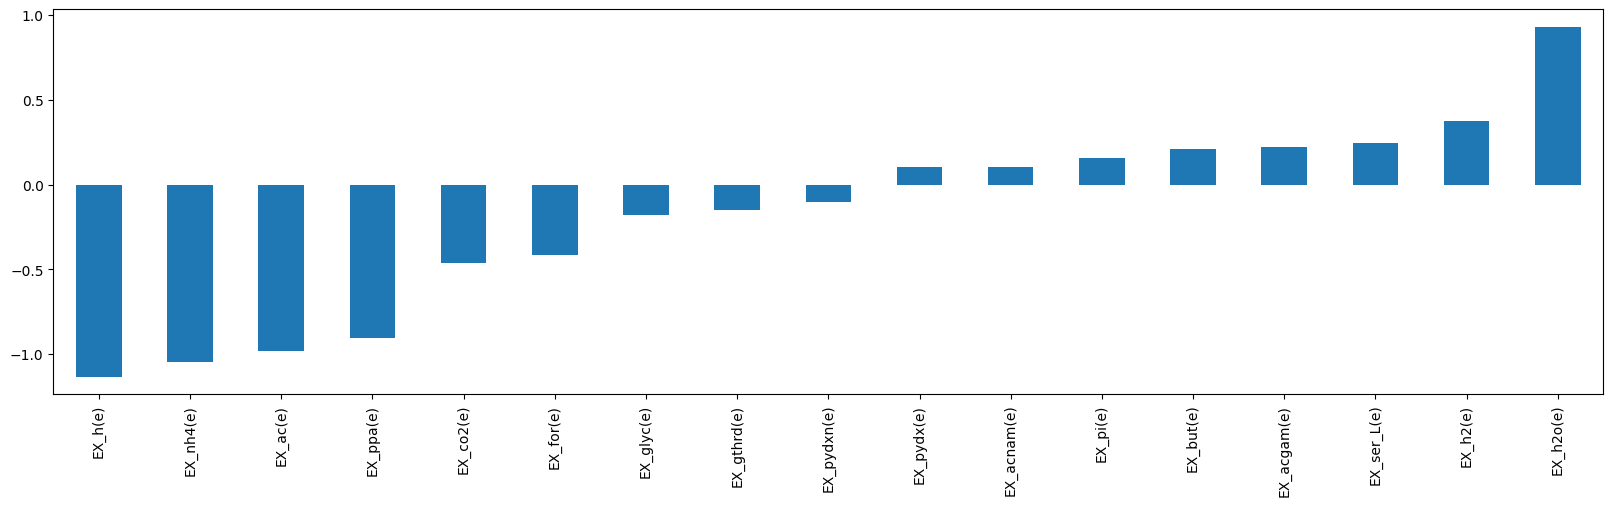

In [15]:
tmp = Deltas["total"].sum()
(tmp[tmp.abs()>0.1]).sort_values().plot.bar(figsize=(20,5))

In [16]:
mets = Deltas["total"].sum().abs().sort_values(ascending=False).index
mets

Index(['EX_h(e)', 'EX_nh4(e)', 'EX_ac(e)', 'EX_h2o(e)', 'EX_ppa(e)',
       'EX_co2(e)', 'EX_for(e)', 'EX_h2(e)', 'EX_ser_L(e)', 'EX_acgam(e)',
       ...
       'EX_idour(e)', 'EX_Lcyst(e)', 'EX_r34hpp(e)', 'EX_starch1200(e)',
       'EX_glutar(e)', 'EX_12dhchol(e)', 'EX_bglc(e)', 'EX_f1a(e)',
       'EX_tdchola(e)', 'EX_7ocholate(e)'],
      dtype='object', length=325)

In [17]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,Producing)
Delta = Delta.fillna(0.)
Deltas["producing"] = Delta

/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Anno

In [18]:
Delta = pandas.DataFrame()
for m in mets:
    Delta[m] = get_delta_met(m,Consuming)
Delta = Delta.fillna(0.)
Deltas["consuming"] = Delta

/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]
/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Anno

In [19]:
def add_total(df):
    df = df.T
    df["Total"] = df.sum(axis=1)
    return df.T
SaveDeltas = {k:add_total(df) for k,df in Deltas.items()}
save_dict_of_dataframes_to_excel(SaveDeltas,"SupplementaryFile-Deltas.xlsx")

### Heatmap

In [20]:
mets = Deltas["total"].sum().abs().sort_values(ascending=False).head(10).index
mets

Index(['EX_h(e)', 'EX_nh4(e)', 'EX_ac(e)', 'EX_h2o(e)', 'EX_ppa(e)',
       'EX_co2(e)', 'EX_for(e)', 'EX_h2(e)', 'EX_ser_L(e)', 'EX_acgam(e)'],
      dtype='object')

In [21]:
Deltas["total"].sum().sort_values(ascending=False).head(10)

EX_h2o(e)      0.931817
EX_h2(e)       0.376775
EX_ser_L(e)    0.245079
EX_acgam(e)    0.220378
EX_but(e)      0.209197
EX_pi(e)       0.156116
EX_acnam(e)    0.103067
EX_pydx(e)     0.102319
EX_uri(e)      0.092569
EX_2obut(e)    0.082591
dtype: float64

In [22]:
Totals = pandas.DataFrame()

Totals["Producing-nonIBD"] = Producing["nonIBD"].sum(1)
Totals["Consuming-nonIBD"] = Consuming["nonIBD"].sum(1)

Totals["Producing-IBD"] = Producing["IBD"].sum(1)
Totals["Consuming-IBD"] = Consuming["IBD"].sum(1)

Totals.fillna(0.)

Totals["nonIBD"] = Totals["Producing-nonIBD"] - Totals["Consuming-nonIBD"]
Totals["IBD"] = Totals["Producing-IBD"] - Totals["Consuming-IBD"]
Totals["Net"] = Totals["IBD"] - Totals["nonIBD"]

Totals = Totals[["nonIBD","IBD","Net"]].T[list(set(mets) & set(Totals.index))]
Totals

,EX_for(e),EX_ser_L(e),EX_h(e),EX_acgam(e),EX_co2(e),EX_nh4(e),EX_h2o(e),EX_ac(e),EX_h2(e),EX_ppa(e)
nonIBD,2.934210,-0.570681,4.840771,-0.481199,1.007886,2.325088,-2.905490,3.301429,0.318217,1.486348
IBD,2.522399,-0.325602,3.706603,-0.260821,0.545510,1.277931,-1.973673,2.318357,0.694992,0.581302
Net,-0.411811,0.245079,-1.134168,0.220378,-0.462376,-1.047157,0.931817,-0.983072,0.376775,-0.905047


In [23]:
cutoff = 0.01

In [24]:
tmp = Deltas["producing"].copy()
tmp[tmp.abs()<cutoff] = 0
TotalsProducing = tmp[tmp.any(axis=1)]
TotalsProducing

,EX_h(e),EX_nh4(e),EX_ac(e),EX_h2o(e),EX_ppa(e),EX_co2(e),EX_for(e),EX_h2(e),EX_ser_L(e),EX_acgam(e),...,EX_idour(e),EX_Lcyst(e),EX_r34hpp(e),EX_starch1200(e),EX_glutar(e),EX_12dhchol(e),EX_bglc(e),EX_f1a(e),EX_tdchola(e),EX_7ocholate(e)
Genus,,,,,,,,,,,,,,,,,,,,,
Akkermansia,0.027808,0.012677,0.019052,0.000000,0.000000,0.000000,0.024364,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alistipes,0.010417,0.000000,0.010596,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bacteroides,-1.159066,-0.674800,-0.960300,0.000000,-0.270455,-0.223804,-0.722358,-0.053051,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dorea,0.019938,0.000000,0.016407,0.000000,0.000000,0.000000,0.017150,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enterocloster,0.101094,0.012151,0.040516,0.000000,0.000000,0.000000,0.010115,0.018393,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Escherichia,0.075569,0.048377,0.095858,0.000000,0.000000,0.016636,0.064508,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Faecalibacterium,-0.393070,-0.188556,-0.430923,0.000000,0.000000,-0.126376,-0.323107,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Holdemania,0.022690,0.013774,0.012745,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lachnoclostridium,0.000000,0.000000,0.034053,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
tmp = Deltas["consuming"].copy()
tmp[tmp.abs()<cutoff] = 0
TotalsConsuming = tmp[tmp.any(axis=1)]
TotalsConsuming

,EX_h(e),EX_nh4(e),EX_ac(e),EX_h2o(e),EX_ppa(e),EX_co2(e),EX_for(e),EX_h2(e),EX_ser_L(e),EX_acgam(e),...,EX_idour(e),EX_Lcyst(e),EX_r34hpp(e),EX_starch1200(e),EX_glutar(e),EX_12dhchol(e),EX_bglc(e),EX_f1a(e),EX_tdchola(e),EX_7ocholate(e)
Genus,,,,,,,,,,,,,,,,,,,,,
Akkermansia,0.000000,0.0,0.0,0.017886,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bacteroides,-0.010387,0.0,0.0,-0.777503,0.0,0.0,0.0,-0.013848,-0.194521,-0.160787,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Dialister,0.000000,0.0,0.0,-0.015315,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Enterocloster,0.000000,0.0,0.0,0.011411,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Escherichia,0.000000,0.0,0.0,0.048190,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Faecalibacterium,0.000000,0.0,0.0,-0.360256,0.0,0.0,0.0,0.000000,-0.074749,-0.074749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Holdemania,0.000000,0.0,0.0,0.010129,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Lachnospira,0.000000,0.0,0.0,0.126734,0.0,0.0,0.0,0.000000,0.000000,0.012836,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Phocaeicola,0.000000,0.0,0.0,-0.588369,0.0,0.0,0.0,0.000000,-0.076798,-0.073198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Change in ')

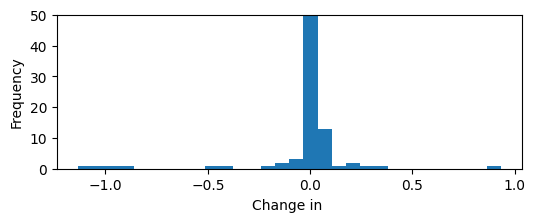

In [26]:
Deltas["total"].sum().sort_values().plot.hist(bins=30,figsize=(6,2))
plt.ylim([0,50])
plt.xlabel("Change in ")

### Plots

In [27]:
Deltas["total"]["EX_but(e)"].sort_values()

Genus
unclassified Lachnospiraceae   -0.059720
Faecalibacterium               -0.010139
Butyricicoccus                 -0.000126
Clostridioides                 -0.000005
Holdemanella                   -0.000004
                                  ...   
Anaerostipes                    0.000622
Erysipelatoclostridium          0.001159
unclassified Ruminococcaceae    0.001263
Odoribacter                     0.001615
Roseburia                       0.271877
Name: EX_but(e), Length: 169, dtype: float64

In [28]:
Deltas["producing"]["EX_but(e)"].sort_values()

Genus
unclassified Lachnospiraceae   -0.059720
Faecalibacterium               -0.010139
Butyricicoccus                 -0.000126
Clostridioides                 -0.000005
Holdemanella                   -0.000004
                                  ...   
Anaerostipes                    0.000622
Erysipelatoclostridium          0.001159
unclassified Ruminococcaceae    0.001263
Odoribacter                     0.001615
Roseburia                       0.271877
Name: EX_but(e), Length: 169, dtype: float64

In [29]:
Deltas["consuming"]["EX_but(e)"].sort_values()

Genus
Abiotrophia                     0.0
Mediterraneibacter              0.0
Megasphaera                     0.0
Methylobacterium                0.0
Methylorubrum                   0.0
                               ... 
Delftia                         0.0
Desulfovibrio                   0.0
Dialister                       0.0
Coprococcus                     0.0
unclassified Ruminococcaceae    0.0
Name: EX_but(e), Length: 169, dtype: float64

In [30]:
Deltas["producing"].loc["Butyricimonas"]

EX_h(e)           -7.406919e-06
EX_nh4(e)          2.667336e-05
EX_ac(e)          -5.836253e-10
EX_h2o(e)         -1.458037e-06
EX_ppa(e)          0.000000e+00
                       ...     
EX_12dhchol(e)     0.000000e+00
EX_bglc(e)         0.000000e+00
EX_f1a(e)          0.000000e+00
EX_tdchola(e)      0.000000e+00
EX_7ocholate(e)    0.000000e+00
Name: Butyricimonas, Length: 325, dtype: float64

In [31]:
Deltas["total"].sum().sort_values()

EX_h(e)       -1.134168
EX_nh4(e)     -1.047157
EX_ac(e)      -0.983072
EX_ppa(e)     -0.905047
EX_co2(e)     -0.462376
                 ...   
EX_but(e)      0.209197
EX_acgam(e)    0.220378
EX_ser_L(e)    0.245079
EX_h2(e)       0.376775
EX_h2o(e)      0.931817
Length: 325, dtype: float64

In [32]:
plt.rcParams['svg.fonttype'] = 'none'

In [33]:
# lengths = Totals.shape[0],TotalsProducing.shape[0],TotalsConsuming.shape[0]
lengths = TotalsProducing.shape[0],TotalsConsuming.shape[0]

In [34]:
lengths

(18, 11)

/tmp/ipykernel_43272/3086721220.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()
/tmp/ipykernel_43272/3086721220.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu_r').copy()
/tmp/ipykernel_43272/3086721220.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu').copy()


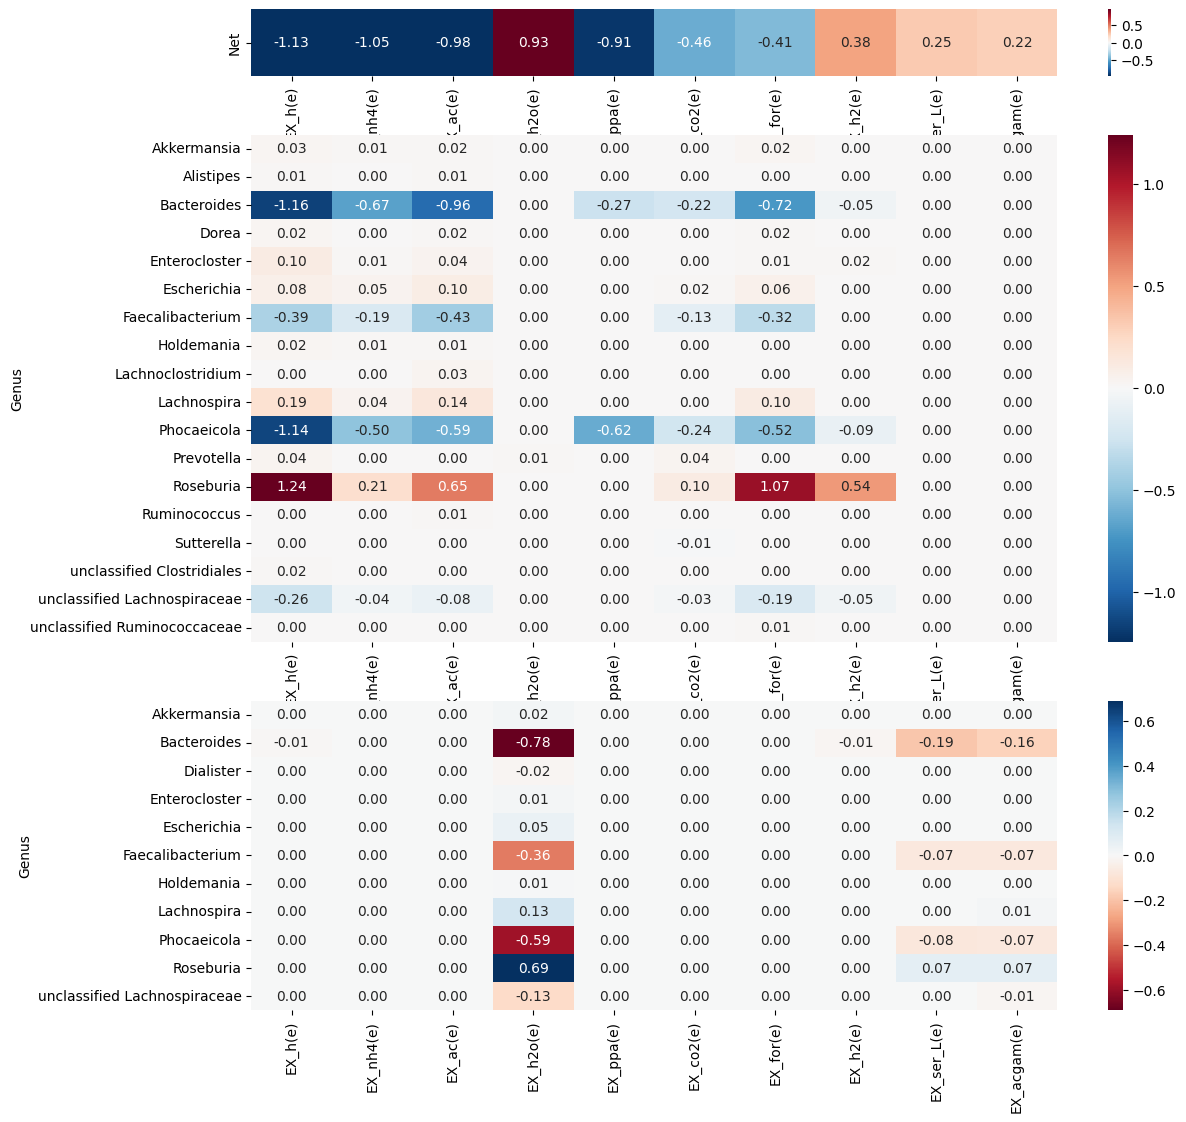

In [35]:
topratio = 0.075
rest = 1 - topratio
fig,ax = plt.subplots(3,1,gridspec_kw={"height_ratios": [topratio, rest*(lengths[0]/sum(lengths)),rest*(lengths[1]/sum(lengths))]},figsize=(13,13))

cmap_df = Totals[mets].copy().loc[["Net"]]
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[0]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

cmap_df = TotalsProducing[mets].copy()
cmap = plt.cm.get_cmap('RdBu_r').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[1]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

cmap_df = TotalsConsuming[mets].copy()
cmap = plt.cm.get_cmap('RdBu').copy()
# cmap.set_under('white')
vmin,vmax = -cmap_df.max().max(),cmap_df.max().max()
cmap = sns.heatmap(cmap_df,
               vmin=vmin,
               vmax=vmax,
               annot=True,
               fmt=".2f",
               cmap=cmap,
               ax=ax[2]
               # annot_kws={'rotation': 90}
               # figsize=(1.0*cmap_df.shape[1],(0.3)*cmap_df.shape[0]),
               # cbar=False,
              )

plt.savefig("./figures/3.7.2.GenusOverflowContributions.svg",format="SVG")

Pyruvate is higher

https://www.frontiersin.org/journals/endocrinology/articles/10.3389/fendo.2023.1242991/full

SCFA are lower 

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6421268/#:~:text=Bacteria%20that%20ferment%20fibers%20and,metabolites%20in%20maintaining%20intestinal%20homeostasis.

pH increases

https://pubmed.ncbi.nlm.nih.gov/9701532/#:~:text=Results%3A%20The%20median%20gastric%20pH,%2C%20range%200.95%2D2.6).
https://link.springer.com/article/10.1023/A:1026664105112

Serine proteases are at the highest activity

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7011180/

### Abundance

In [36]:
RelativeAbundances = pandas.read_csv("./ibdmdb/metaG_per_diagnosis.csv",index_col=0)[["nonIBD","IBD"]]

In [37]:
tmp = RelativeAbundances
tmp[tmp<0.01] = 0
tmp = tmp[tmp.any(axis=1)]

/tmp/ipykernel_43272/1988653722.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  FluxByGenus = FluxByOrg_Annotated.groupby(Taxa).sum()[["nonIBD","IBD"]]


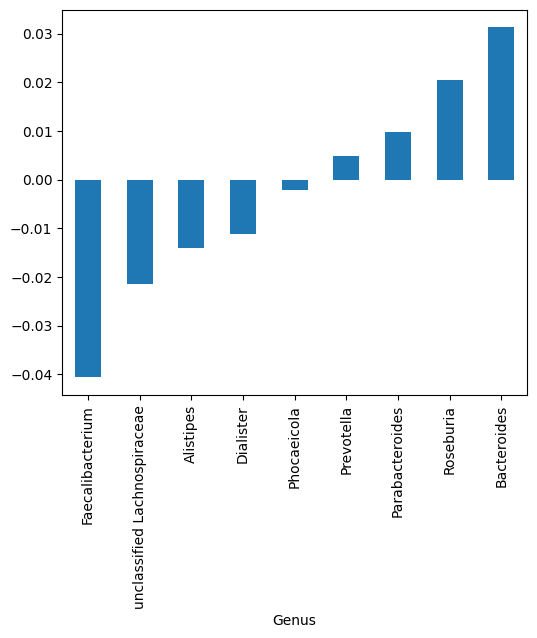

In [38]:
get_delta(tmp,"Genus").sort_values().plot.bar(figsize = (6,5))
plt.savefig("./figures/3.7.2.GenusDeltaRelativeAbundances.svg",format="SVG")

In [39]:
Deltas["producing"]["EX_gthrd(e)"].sort_values()

Genus
Faecalibacterium               -0.149499
Abiotrophia                     0.000000
Megasphaera                     0.000000
Methylobacterium                0.000000
Methylorubrum                   0.000000
                                  ...   
Delftia                         0.000000
Desulfovibrio                   0.000000
Dialister                       0.000000
Coprococcus                     0.000000
unclassified Ruminococcaceae    0.000000
Name: EX_gthrd(e), Length: 169, dtype: float64

In [40]:
Deltas["total"]["EX_but(e)"].sum()

0.2091974350956631

In [41]:
tmp = Deltas["total"].T

In [42]:
tmp[tmp.index.str.contains("EX_[a-z]{6}\(e\)")].sum(axis=1).sort_values()

EX_indole(e)   -2.264559e-03
EX_adocbl(e)   -2.057199e-03
EX_trypta(e)   -5.093404e-05
EX_isoval(e)   -4.660981e-05
EX_glyclt(e)   -5.041912e-06
EX_lanost(e)   -1.792128e-10
EX_glypro(e)   -7.678799e-22
EX_alagln(e)   -1.340656e-22
EX_alahis(e)   -1.337361e-22
EX_alaglu(e)   -1.304220e-23
EX_glyglu(e)   -2.668804e-24
EX_glytyr(e)   -2.307842e-24
EX_glyasn(e)   -2.033543e-24
EX_glyphe(e)   -1.936687e-24
EX_alagly(e)   -1.907682e-24
EX_malttr(e)   -1.507304e-24
EX_glygln(e)   -8.337379e-25
EX_alaleu(e)   -2.881132e-25
EX_dgchol(e)   -5.162522e-28
EX_gchola(e)   -5.162522e-28
EX_sulfac(e)   -1.542797e-28
EX_isetac(e)   -2.647632e-29
EX_dhpppn(e)   -8.864908e-52
EX_glutar(e)    0.000000e+00
EX_arsenb(e)    2.080534e-54
EX_glycys(e)    9.997730e-27
EX_metala(e)    1.598620e-25
EX_glyleu(e)    2.260824e-25
EX_malthx(e)    3.164152e-25
EX_alathr(e)    4.567143e-25
EX_alaasp(e)    6.695450e-25
EX_glyasp(e)    6.925982e-25
EX_glymet(e)    2.664400e-24
EX_cellul(e)    1.997585e-09
EX_ocdcea(e)  